# 3. Scores Generator (A)

We have divided this notebook into the following parts:

1. Load **matrix**: We load a CSV file with the preprocessed matrix. 
2. Load **model**: Using hugging face API, we load a pre-trained or a fine-tuned model and apply it to the said matrix to obtain corresponding predictions.

3. **Model-specific preprocessing**: We apply model specific fine-tuning that is related with how the models were trained to encode the strings.
3. Create **preds**: We create a CSV file with the predictions concerning the model to evaluate.

**Note**: We assume that all matrices have a set of `ID_COLS` that uniquely identifies each row. Additionally, for multi-way (or multi-annotated) datasets, we assume a row-wise format, that is, all the necessary data has already been unrolled  along the first dimension. For example, let us consider a __source dataset__ with $200$ examples, where each of them comprises two different annotations. This notebook __assumes that dataset was previously preprocessed__ and is __now unflattened__ totalling $400$ rows (one per example and annotation) when loaded from memory. While this duplicates memory, it avoids having complex pipelines with intrinsic hand-tailored routines for each dataset (i.e., _bye bye spaghetti_ code).

In [1]:
OUTPUT_DIR = "../outputs"

MODEL_NAME = "allenai/unifiedqa-t5-small"
#model_name = "t5-small"

# name of the dataset to preprocess
DATASET_NAME, SPLIT_NAME = "squad", "validation"
# DATASET_NAME, SPLIT_NAME = "newsqa", "dev"
# DATASET_NAME, SPLIT_NAME = ('squadshifts', 'new_wiki'), "test"
# DATASET_NAME, SPLIT_NAME = ('squadshifts', 'nyt'), "test"
# DATASET_NAME, SPLIT_NAME = ('squadshifts', 'amazon'), "test"
# DATASET_NAME, SPLIT_NAME = ('squadshifts', 'reddit'), "test"
# DATASET_NAME, SPLIT_NAME = "narrativeqa", "test_5k_sample_seed_2022"
# DATASET_NAME, SPLIT_NAME = "narrativeqa", "test_len_10"


IS_LOCAL_FS_DATASET = True if DATASET_NAME in ("newsqa", "narrativeqa") else False

if isinstance(DATASET_NAME, tuple):
    NORMALIZED_DATASET_NAME = "".join(DATASET_NAME)
else:
    NORMALIZED_DATASET_NAME = DATASET_NAME

BASE_FILENAME = f"{NORMALIZED_DATASET_NAME}_{SPLIT_NAME}"


ROOT_DIR = f"{OUTPUT_DIR}/results/{NORMALIZED_DATASET_NAME}/{SPLIT_NAME}"

MATRIX_DIR = f"{ROOT_DIR}/matrix"
MATRIX_FILEPATH = f"{MATRIX_DIR}/{BASE_FILENAME}_preprocessed.csv"

# Outputs
PREDS_DIR = f"{ROOT_DIR}/preds"
!mkdir -p {PREDS_DIR}

SEED = 42
# Arguments used to read the files from disk
csv_kwargs = {
   "compression": "gzip",
   "encoding": "utf-8",
}

# ----------------------------------------
## Columns names
# ----------------------------------------
ID_COLS = ["example_id", "answer_id"]

UNIQUE_ID_COL = ID_COLS[0]
NON_UNIQUE_ID_COL = ID_COLS[1]
print("Using", UNIQUE_ID_COL, "as the unique column to de-duplicate the data")

Using example_id as the unique column to de-duplicate the data


## Load matrix 

This is the preprocessed matrix that will be used by every model when creating predictions. We expect it to  have the following columns:
- `ID_COLS: List[str]`, can be one or more set of unique identifier columns.
- `TOPIC: str`, optional, provides a high-level categorization of the different examples.

- Dataset specific columns, such as `CONTEXT`, `QUESTION`, `ANSWER` for open-book (closed-domain) QA tasks. Amongst these we usually define the `TARGET_LABEL` and the `FEATURES` the ones that will be encoded together for generative purposes.


By default we will assume the following columns:
- `TARGET_LABEL = 'label'`
- `FEATURES = ['question', 'context']`


**Note**: ~~May have to reconsider the use of pandas, for larger datasets, since it wont be feasible to hold them in memory. Instead, may consider HuggingFace `datasets` or `pyspark`.~~ Consider [building script](https://huggingface.co/docs/datasets/loading_datasets.html#from-local-or-remote-files) in case more demanding needs arise.

In [2]:
import pandas as pd
import numpy as np

import datasets

/home/kat/miniconda3/envs/gqa-env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
TARGET_LABEL = "label"
FEATURES = ["question", "context"]

In [4]:
import datasets
matrix = datasets.load_dataset('csv', data_files=MATRIX_FILEPATH)["train"]
print("Loaded", len(matrix), "datapoints from", MATRIX_FILEPATH)

Using custom data configuration default-c08f75ec88dbd2c1
Reusing dataset csv (/home/kat/.cache/huggingface/datasets/csv/default-c08f75ec88dbd2c1/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 204.47it/s]

Loaded 3205 datapoints from ../outputs/results/narrativeqa/test_len_10/matrix/narrativeqa_test_len_10_preprocessed.csv


### Remove duplicate entries when generating predictions

In [5]:
from utils.datasets import drop_duplicates

In [6]:
matrix = drop_duplicates(matrix, UNIQUE_ID_COL)
print("Remaining", len(matrix), "datapoints after dropping duplicates")

Loading cached processed dataset at /home/kat/.cache/huggingface/datasets/csv/default-c08f75ec88dbd2c1/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-7eef85e8c22c570e.arrow


Remaining 3205 datapoints after dropping duplicates


In [7]:
matrix = matrix.shuffle(seed=42)
matrix

Loading cached shuffled indices for dataset at /home/kat/.cache/huggingface/datasets/csv/default-c08f75ec88dbd2c1/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-b054b0f1180ed0be.arrow


Dataset({
    features: ['example_id', 'title', 'question', 'context', 'labels', 'multi_way_labels', 'answer_id', 'question_len', 'context_len', 'labels_len'],
    num_rows: 3205
})

## Load model

Using HF's API, we load a pre-trained or a fine-tuned model and apply it to the said matrix to obtain corresponding predictions.


In [8]:
from models.model import T5Model, UnifiedQAT5Model

if "unified" in MODEL_NAME:
    print("Using UnifiedQA:", MODEL_NAME)
    MODEL = UnifiedQAT5Model
elif "t5" in MODEL_NAME:
    print("Using T5 model:", MODEL_NAME)
    MODEL = T5Model
else:
    raise NotImplementedError

Using UnifiedQA: allenai/unifiedqa-t5-base


In [9]:
model_hf_kwargs = {
    # Path to directory to store the pretrained models
    # (may make ensuing analysis faster)
    "cache_dir": f"{OUTPUT_DIR}/model/cache",
    # Specific version of the model to use (defaults to main)
    # "revision": "main",
}

model_hyperparameters = {
    "padding": "max_length",
    "max_length": 512,
    
    "truncation": True,
    "add_special_tokens": True,
    "return_attention_mask": True,
    # All generate-specific kwargs should start with the prefix "generate_" 
    "generate__max_length": 100,
    "generate__batch_size": 700,
}

model = MODEL(MODEL_NAME, model_hyperparameters, model_hf_kwargs)
model.load()

## Generate predictions
Using the model and the preprocessed matrix, generate the predictions. 
The predictions files will contain the following information:

Useful resources:
- [dataset and Pytorch](https://huggingface.co/docs/datasets/use_dataset.html)
- [fine-tuning a pretrained model](https://huggingface.co/course/chapter3/4?fw=pt)
- [generator](https://huggingface.co/docs/transformers/v4.16.2/en/internal/generation_utils#transformers.generation_utils.GreedySearchDecoderOnlyOutput)

### Model-tailored Preprocessing

We apply model specific fine-tuning that is related with how the models were trained to encode the strings. We will apply this on a per-batch basis to avoid additional overhead in iterating the datasets. We use the [`datasets.Dataset.set_format`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasets.Dataset.set_format) as a more efficient way to cast the necessary columns to pytorch structures. 


In [10]:
matrix_fmt = matrix.map(model._format_row, fn_kwargs={"features": FEATURES})
matrix_fmt = matrix_fmt.map(lambda examples: model.encode(examples, 'encoded'), batched=True)
matrix_fmt.set_format(type="torch", columns=["input_ids", "attention_mask"], output_all_columns=False)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.81ba/s]


### Creating Greedy Predictions

We want to be able to create predictions both for __beam search__ and for __greedy search__. We will focus for now in the case when we have a single return sequence (even though we can have multiple beams or multiple paths explored).

A predictions matrix will have the following attributes/columns:
- `ID_COLUMNS`: ideally comprised of the unique identifiers you specified in the beginning.
- `pred_id`: unique identifier for each example (computed for each instance based on the model_uuid and the generated tokens).
- `score_proba`: score associated with the generated sentence. computed as the multiplication of the individual raw_scores. the score is within $[0, 1]$.
- `preds`: textual representation of the generated instance
- `preds_raw_int`: tokens id 
- `preds_raw_str`: tokens str
- `preds_raw_scores`: scores for each of the tokens, lie in the range $[0, 1]$.
- `len`: length of the sentence
- `truncated`: whether the sequence was truncated (i.e., actually had the eos token).

In [11]:
from models.predictions import GreedyGenerator
from utils_generic import filter_params_by_prefix

In [14]:
GENERATE_PREFIX = "generate__"

model_generate_hyperparams = filter_params_by_prefix(model_hyperparameters, GENERATE_PREFIX)
model_generate_hyperparams = {param_name[len(GENERATE_PREFIX):]: param_val for param_name, param_val in model_generate_hyperparams.items()}
print("Generator kwargs:", model_generate_hyperparams)


print("Creating **Greedy Generator**")
# generator = GreedyGenerator()

# print("Generating...")
# batches = generator.generate(
#     data=matrix_fmt,
#     id_cols=ID_COLS,
#     model=model._model,
#     tokenizer=model._tokenizer,
#     **model_generate_hyperparams,
# )

Generator kwargs: {'max_length': 100, 'batch_size': 700}
Creating **Greedy Generator**


In [37]:
from itertools import filterfalse
from utils_generic import generate_uuid

import logging
import pandas as pd
import scipy.stats as st
import torch
import torch.nn
import torch.nn.functional as F


class GreedyGenerator:
    def __init__(self):
        super().__init__()
        self._num_beams = 1
        self._do_sample = False
        self._clean_up_tokenization_spaces = True
        self._skip_special_tokens = True

    @property
    def generate_hyperparams(self) -> dict:
        return {
            "num_beams": self._num_beams,
            "do_sample": self._do_sample,
        }

    @property
    def decoding_hyperparams(self) -> dict:
        return {
            "clean_up_tokenization_spaces": self._clean_up_tokenization_spaces,
            "skip_special_tokens": self._skip_special_tokens,
        }

    def generate(
        self, data, id_cols, tokenizer, model, batch_size: int = None, **kwargs
    ) -> dict:
        """
        - `score_proba`: score associated with the generated sentence. computed as the multiplication of the individual raw_scores. the score is within $[0, 1]$.
        - `preds`: textual representation of the generated instance
        - `preds_raw_int`: tokens id
        - `preds_raw_str`: tokens str
        - `preds_raw_scores`: scores for each of the tokens, lie in the range $[0, 1]$.
        - `len`: length of the sentence
        - `truncated`: whether the sequence was truncated (i.e., actually had the eos token).
        """
        if batch_size is None:
            batch_size = len(data)
        else:
            batch_size = min(batch_size, len(data))

        n = len(data)
        logging.info(f"Processing {n} examples in total")
        for b_start in range(0, n, batch_size):
            metadata = {}
            # Batch indexing
            # ---------------------------------------------------------------
            b_end = b_start + batch_size
            b_end = min(b_end, n)
            batch = data.select(range(b_start, b_end))
            # logging.info(f"Processing examples {b_start}-{b_end} (out of {n})")
            print(f"Processing examples {b_start}-{b_end} (out of {n})")

            metadata.update({id_col: batch[id_col] for id_col in id_cols})

            # Generate
            # ---------------------------------------------------------------
            results = model.generate(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                # We're interested in returning information about the scores
                output_scores=True,
                return_dict_in_generate=True,
                # Force truncation (ensure the last token is always the EOS)
                forced_eos_token_id=tokenizer.eos_token_id,
                **self.generate_hyperparams,
                **kwargs,  # max_length
            )

            # Textual representation of the predicted sequence
            metadata["preds"] = tokenizer.batch_decode(
                results.sequences, **self.decoding_hyperparams
            )

            # Compute unique identifiers for each prediction
            # Ideally the identifier will depend on the model's,
            # the tokenizer's and the matrix's uuid but for now
            # we will simplify and only consider the generated text.
            #
            # Note: This assumes the name of the prediction file is being
            # handled by some component that has access to all this information
            # and is, therefore, able to avoid name clashes.
            uuid_metadata = {}
            uuid = lambda pred: generate_uuid(dict(text=pred, **uuid_metadata))
            metadata["preds_id"] = [uuid(pred) for pred in metadata["preds"]]

            # Individual tokens raw representation
            def skip_tokens(seq, token):
                predicate = filterfalse(lambda t: t == token, seq)
                return list(predicate)

            metadata["preds_raw_int"] = results.sequences.tolist()
            metadata["preds_raw_int"] = [
                skip_tokens(s, tokenizer.pad_token_id)
                for s in metadata["preds_raw_int"]
            ]

            # Individual tokens raw textual representation
            # metadata["preds_raw_str"] = [[tokenizer.decode(t, skip_special_tokens=True) for t in seq]
            metadata["preds_raw_str"] = [
                tokenizer.convert_ids_to_tokens(seq, skip_special_tokens=True)
                for seq in metadata["preds_raw_int"]
            ]

            # Individual tokens count (does not include special tokens like EOS or pad)
            metadata["preds_raw_count"] = list(map(len, metadata["preds_raw_str"]))

            # Whether the sentence was truncated or not (i.e., it has an EOS token)
            is_truncated = lambda s: int(any(s == tokenizer.eos_token_id))
            metadata["truncated"] = [is_truncated(seq) for seq in results.sequences]

            # ---------------------------------------------------------------------------------
            # Compute score_proba
            # ---------------------------------------------------------------------------------
            # Pair each timestep logits `score_t` with corresponding generated token
            # *Note*: since greedy_results.scores is a T sized tuple with B * V matrices
            # representing the logits for the different instances in the batch at each timestep
            # we can couple the actual logit score at each timestep with the corresponding token.
            scores, seq_tokens = results.scores, results.sequences[:, 1:]
            # ^Note: The sequences are considering an initial pad token whose score is not outputted
            # by the greedy decoder.
            assert (
                len(scores) == seq_tokens.shape[-1]
            ), "Dimension mismatch: Sequences vs scores"

            n_pred_timesteps = len(scores)

            scores_tokens = []
            entropy_per_timestep = []
            margin_per_timestep = []
            margin_str_per_timestep = []
            for t in range(n_pred_timesteps): 
                scores_t = F.log_softmax(scores[t], dim=-1)
                seq_tokens_t = seq_tokens[:, t]
                scores_tokens.append((scores_t, seq_tokens_t))
                # ^Note:
                # - `scores` is a |B| X |V| matrix with all the logits per batch per vocabulary
                # at prediction timestep t. Like Jiang et. al
                # (https://github.com/jzbjyb/lm-calibration/blob/887e3e13df0462842ce288fffe588e549a3360ee/model/gpt2.py#L67)
                # we apply F.log_softmax to ensure the logprobabilities are comparable amongst
                # the different batches
                # - `seq_tokens[:, t]` is a |B| X 1 matrix with the predicted token types at
                # timestep t
                entropy_t = st.entropy(torch.exp(scores_t), axis=-1).reshape(-1, 1)
                # ^Note: this returns a tensor |B| * 1
                entropy_per_timestep.append(entropy_t)
                
                # Compute margin
                topk_values, topk_indices = torch.topk(scores_t, 2, dim=-1)
                margin = torch.exp(topk_values.max(dim=-1).values) - torch.exp(topk_values.min(dim=-1).values)
                margin_per_timestep.append(margin.reshape(-1, 1))
                
                margin_strs = tokenizer.convert_ids_to_tokens(
                    topk_indices[:,-1], skip_special_tokens=False)
                margin_str_per_timestep.append(np.array(margin_strs).reshape(-1, 1))
                del margin_strs
            
            entropy_per_timestep = np.hstack(entropy_per_timestep)
            margin_per_timestep = np.hstack(margin_per_timestep)
            margin_str_per_timestep = np.hstack(margin_str_per_timestep)

            greedy_scores = [
                scores_t.gather(-1, token_t.unsqueeze(-1))
                for scores_t, token_t in scores_tokens
            ]
            greedy_scores = torch.cat(greedy_scores, dim=1)
            # Must mask the greedy scores corresponding to the padding
            pad_mask = seq_tokens == tokenizer.pad_token_id
            greedy_scores[pad_mask] = 0
            entropy_per_timestep[pad_mask] = 0
            margin_per_timestep[pad_mask] = 0
            margin_str_per_timestep[pad_mask] = 0

            metadata["score_proba"] = torch.exp( # TODO: CHANGE
                torch.sum(greedy_scores, dim=1)
            ).tolist()
            metadata["preds_raw_scores"] = torch.exp(greedy_scores).tolist() # TODO: CHANGE

            # Drop the tokens that are not important
            metadata["preds_raw_scores"] = [
                skip_tokens(s, 1) for s in metadata["preds_raw_scores"]
            ]
            
            metadata["entropy"] = entropy_per_timestep.tolist()
            metadata["margin"] = margin_per_timestep.tolist()
            metadata["margin_str"] = [
                skip_tokens(s, '</s>') for s in margin_str_per_timestep
            ]

            del results
            del scores
            del seq_tokens
            del greedy_scores
            del pad_mask
            del topk_values
            del topk_indices
            del entropy_t
            del entropy_per_timestep
            del margin_per_timestep
            del margin_str_per_timestep
            
            yield pd.DataFrame(metadata)
            
            
            
print("Creating **Greedy Generator**")
generator = GreedyGenerator()

print("Generating...")
batches = generator.generate(
    data=matrix_fmt,
    id_cols=ID_COLS,
    model=model._model,
    tokenizer=model._tokenizer,
    **model_generate_hyperparams,
)

Creating **Greedy Generator**
Generating...


## Dump prediction file

In [38]:
from utils.output import OutputResult

In [39]:
# Sanity check (:
out_result = OutputResult(
    filename=BASE_FILENAME + f"_{NORMALIZED_DATASET_NAME}_{SPLIT_NAME}",
    output_dir=PREDS_DIR,
    out_extension="csv.gz",
)

print("Writing predictions at:", out_result.filename)
out_result.write(batches)

Writing predictions at: narrativeqa_test_len_10_narrativeqa_test_len_10
Processing examples 0-700 (out of 3205)
[('example_id', 700), ('answer_id', 700), ('preds', 700), ('preds_id', 700), ('preds_raw_int', 700), ('preds_raw_str', 700), ('preds_raw_count', 700), ('truncated', 700), ('score_proba', 700), ('preds_raw_scores', 700), ('entropy', 700), ('margin', 700), ('margin_str', 700)]
Processing examples 700-1400 (out of 3205)
[('example_id', 700), ('answer_id', 700), ('preds', 700), ('preds_id', 700), ('preds_raw_int', 700), ('preds_raw_str', 700), ('preds_raw_count', 700), ('truncated', 700), ('score_proba', 700), ('preds_raw_scores', 700), ('entropy', 700), ('margin', 700), ('margin_str', 700)]
Processing examples 1400-2100 (out of 3205)
[('example_id', 700), ('answer_id', 700), ('preds', 700), ('preds_id', 700), ('preds_raw_int', 700), ('preds_raw_str', 700), ('preds_raw_count', 700), ('truncated', 700), ('score_proba', 700), ('preds_raw_scores', 700), ('entropy', 700), ('margin', 

In [164]:
df = pd.read_csv(out_result.filepath, compression="gzip", encoding="utf-8")
df.isna().any()

example_id          False
answer_id           False
preds               False
preds_id            False
preds_raw_int       False
preds_raw_str       False
preds_raw_count     False
truncated           False
score_proba         False
preds_raw_scores    False
entropy             False
margin              False
margin_str          False
dtype: bool

In [165]:
df.head(2)

,example_id,answer_id,preds,preds_id,preds_raw_int,preds_raw_str,preds_raw_count,truncated,score_proba,preds_raw_scores,entropy,margin,margin_str
0,9375,7da31aecad2dcf89dca75ebff2600cb0,to establish a socialist commune,8bdb375c73d50c02375ff1303531a643,"[12, 4797, 3, 9, 23737, 9026, 1]","['▁to', '▁establish', '▁', 'a', '▁socialist', ...",6,1,0.068195,"[0.6226814389228821, 0.2500813603401184, 0.971...","[1.3317371606826782, 3.1997714042663574, 0.180...","[0.41016465425491333, 0.0738849937915802, 0.95...","['▁for', '▁help', '▁his', 'he', '▁social', '▁c..."
1,5096,16795ee732e94259e5c9506f8741ff1e,by a laser.,081cee844c4a56463fb852c8afc428ea,"[57, 3, 9, 6124, 5, 1]","['▁by', '▁', 'a', '▁laser', '.']",5,1,0.007803,"[0.38482317328453064, 0.452278196811676, 0.990...","[2.270408868789673, 1.9684985876083374, 0.0893...","[0.07525381445884705, 0.19865837693214417, 0.9...","['▁', '▁the', 'focusing', '▁beam', '.', '0', '..."


## Analysis

In [166]:
import matplotlib.pyplot as plt
import seaborn as sns

In [167]:
df.entropy = df.entropy.apply(eval)
df.margin = df.margin.apply(eval)
df.margin_str = df.margin_str.apply(eval)
df.preds_raw_scores = df.preds_raw_scores.apply(eval)
df.preds_raw_int = df.preds_raw_int.apply(eval)
df.preds_raw_str = df.preds_raw_str.apply(eval)
df

,example_id,answer_id,preds,preds_id,preds_raw_int,preds_raw_str,preds_raw_count,truncated,score_proba,preds_raw_scores,entropy,margin,margin_str
0,9375,7da31aecad2dcf89dca75ebff2600cb0,to establish a socialist commune,8bdb375c73d50c02375ff1303531a643,"[12, 4797, 3, 9, 23737, 9026, 1]","[▁to, ▁establish, ▁, a, ▁socialist, ▁commune]",6,1,0.068195,"[0.6226814389228821, 0.2500813603401184, 0.971...","[1.3317371606826782, 3.1997714042663574, 0.180...","[0.41016465425491333, 0.0738849937915802, 0.95...","[▁for, ▁help, ▁his, he, ▁social, ▁commun, ▁the..."
1,5096,16795ee732e94259e5c9506f8741ff1e,by a laser.,081cee844c4a56463fb852c8afc428ea,"[57, 3, 9, 6124, 5, 1]","[▁by, ▁, a, ▁laser, .]",5,1,0.007803,"[0.38482317328453064, 0.452278196811676, 0.990...","[2.270408868789673, 1.9684985876083374, 0.0893...","[0.07525381445884705, 0.19865837693214417, 0.9...","[▁, ▁the, focusing, ▁beam, ., 0, 0, 0, 0, 0, 0..."
2,5529,b6b25c47425045298e030f910f1ca490,classic mystery structure,d7fc81ea688c39d36915a42fe1b7b387,"[2431, 11100, 1809, 1]","[▁classic, ▁mystery, ▁structure]",3,1,0.121732,"[0.44604942202568054, 0.7534312009811401, 0.99...","[2.2514522075653076, 1.0763826370239258, 0.070...","[0.193317711353302, 0.6173071265220642, 0.9890...","[▁, :, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,5555,17c6b4b946412ece62c5944a7b0b2f18,she poisoned herself with arsenic.,bdba4514a8cfd8e6a7979d59743fb1d3,"[255, 14566, 15, 26, 6257, 28, 1584, 7, 35, 44...","[▁she, ▁poison, e, d, ▁herself, ▁with, ▁ar, s,...",11,1,0.108842,"[0.9803149700164795, 0.2776542901992798, 0.984...","[0.17333601415157318, 2.3816044330596924, 0.08...","[0.9770676493644714, 0.03738813102245331, 0.96...","[▁Lucy, ▁, s, s, ▁her, ▁, son, enia, ically, ...."
4,17248,1c25f0879bc28f82c360563f33bc862a,he guns down a teenager.,b8246373e5b86c26e8c5bb4da38c54e1,"[3, 88, 13731, 323, 3, 9, 12357, 5, 1]","[▁, he, ▁guns, ▁down, ▁, a, ▁teenager, .]",8,1,0.061112,"[0.5868157744407654, 0.9967828989028931, 0.314...","[1.798071265220642, 0.029126081615686417, 2.09...","[0.41568779945373535, 0.9947977066040039, 0.07...","[▁guns, a, ▁shoot, ▁, ▁an, teen, ▁, ., 0, 0, 0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3200,4930,2e0f2899846726c72e4b14c9fc8313e0,"his lost companions, abner, Ghak, and Dian the...",10943247a26d1ed280e8ffd8c1dfdf00,"[112, 1513, 9663, 7, 6, 703, 687, 6, 350, 1541...","[▁his, ▁lost, ▁companion, s, ,, ▁ab, ner, ,, ▁...",17,1,0.015480,"[0.9271297454833984, 0.9172045588493347, 0.985...","[0.5210428833961487, 0.5231022238731384, 0.106...","[0.9124227166175842, 0.8880583643913269, 0.976...","[▁ab, ▁three, ▁friends, ▁ab, ▁Ab, n, ▁and, ▁, ..."
3201,10795,cfe281edcadcdfa0333d5f8789d0afa2,he is beaten and beaten,5b176bafa6b831ba5d978be17c4ca9b7,"[3, 88, 19, 3, 17349, 11, 3, 17349, 1]","[▁, he, ▁is, ▁, beaten, ▁and, ▁, beaten]",8,1,0.000803,"[0.5763415098190308, 0.981558620929718, 0.1844...","[2.3351292610168457, 0.11911114305257797, 4.16...","[0.4544595181941986, 0.9670104384422302, 0.104...","[▁the, a, ▁beat, ▁captured, able, ▁killed, rob..."
3202,11181,86d8904a436072ac10fccc7d5b59035f,a show that shows a normal person's life 24/7.,88c499c807ba05133a354d17449171fd,"[3, 9, 504, 24, 1267, 3, 9, 1389, 568, 31, 7, ...","[▁, a, ▁show, ▁that, ▁shows, ▁, a, ▁normal, ▁p...",14,1,0.106955,"[0.5319324135780334, 0.9819881319999695, 0.882...","[2.107071876525879, 0.1357259899377823, 0.7734...","[0.41592535376548767, 0.9740880727767944, 0.85...","[▁an, ED, ▁normal, ▁showing, ▁, ▁the, e, ▁pers..."
3203,19940,f31c74e598d9dcb4e977eff806bc6483,that he will finish the project and be back in...,23e4b08422badedf95337f993ee5527f,"[24, 3, 88, 56, 1992, 8, 516, 11, 36, 223, 16,...","[▁that, ▁, he, ▁will, ▁finish, ▁the, ▁project,...",16,1,0.018968,"[0.5274246335029602, 0.979270339012146, 0.9987...","[1.1725510358810425, 0.15786103904247284, 0.01...","[0.16305938363075256, 0.9745069742202759, 0.99...","[▁, ▁Patterson, if, ▁would, ▁complete, ▁his, ▁..."


In [168]:
max_len = df.entropy.map(len).max()
max_entropy = np.log(model._tokenizer.vocab_size)

df.entropy = df.entropy.map(lambda s: s + [0] * (max_len - len(s)))
df.margin = df.margin.map(lambda s: s + [0] * (max_len - len(s)))

df.preds_raw_scores = df.preds_raw_scores.map(lambda s: s + [0] * (max_len - len(s)))
df.preds_raw_int = df.preds_raw_int.map(lambda s: s + [0] * (max_len - len(s)))
df.preds_raw_str = df.preds_raw_str.map(lambda s: s + [0] * (max_len - len(s)))

In [169]:
df = df.sort_values(by="preds_raw_count", ascending=False)

entropy_per_timestep = np.vstack(df.entropy.values)
print(entropy_per_timestep.shape)
margin_per_timestep = np.vstack(df.margin.values)
print(margin_per_timestep.shape)
preds_raw_scores = np.vstack(df.preds_raw_scores.values)
print(preds_raw_scores.shape)

df.describe()

(3205, 99)
(3205, 99)
(3205, 99)


,example_id,preds_raw_count,truncated,score_proba
count,3205.000000,3205.000000,3205.0,3.205000e+03
mean,10707.670515,9.531357,1.0,9.604936e-02
std,6063.646637,5.401776,0.0,1.404525e-01
min,0.000000,1.000000,1.0,8.664614e-17
25%,5566.000000,6.000000,1.0,4.767795e-03
50%,10984.000000,9.000000,1.0,3.348174e-02
75%,15842.000000,12.000000,1.0,1.290329e-01
max,21110.000000,98.000000,1.0,8.274604e-01


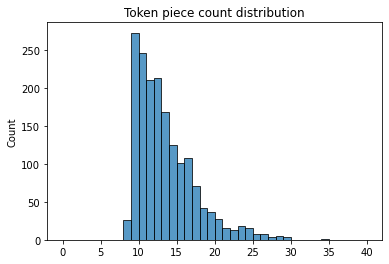

In [170]:
sns.histplot(df.preds_raw_count.values[:1740], binrange=(0, 40), binwidth=1)
plt.title("Token piece count distribution")
plt.show()

Text(0.5, 1.0, 'Logits entropy per answer')

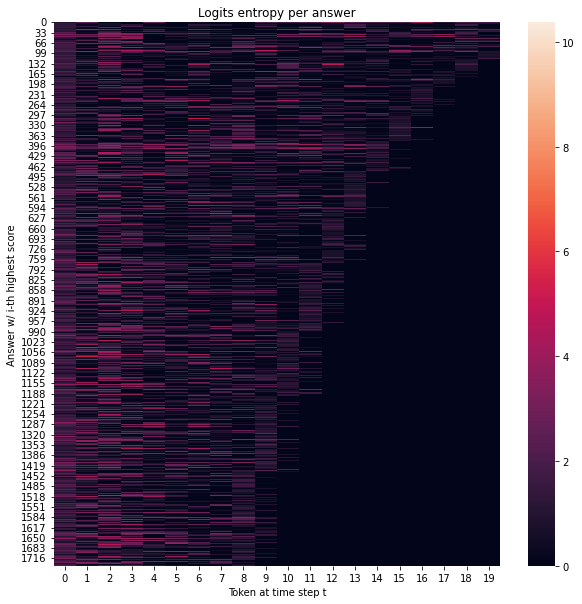

In [171]:
plt.figure(figsize=(10, 10))
sns.heatmap(entropy_per_timestep[:1740,:20], vmin=0, vmax=max_entropy)
plt.xlabel("Token at time step t")
plt.ylabel("Answer w/ i-th highest score")
plt.title("Logits entropy per answer")

Text(0.5, 1.0, 'Margin likelihood at each timestep')

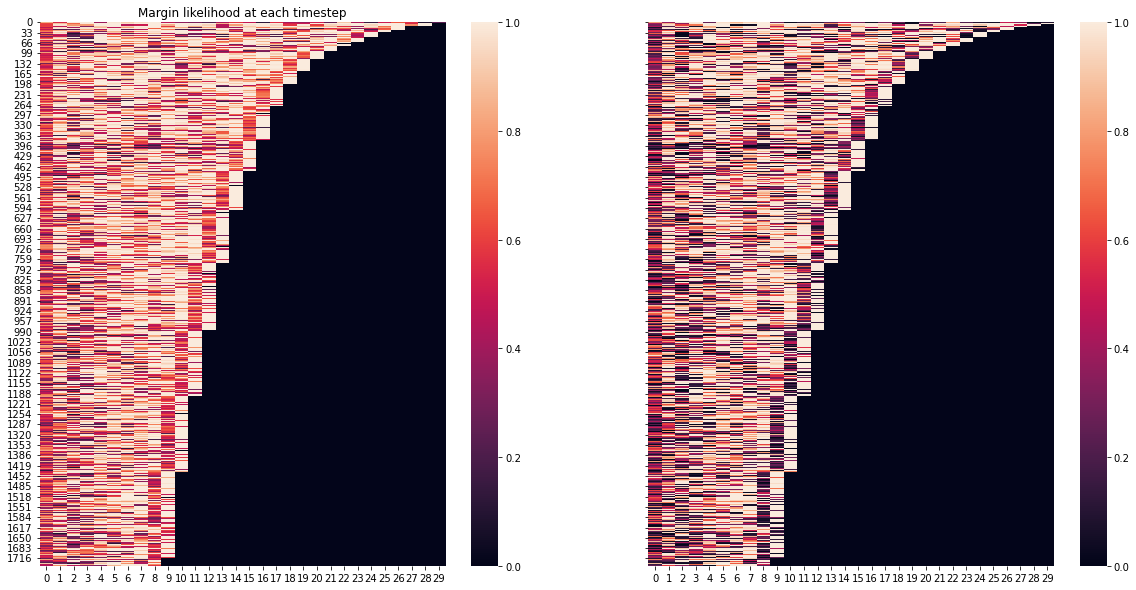

In [172]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(20, 10))

sns.heatmap(preds_raw_scores[:1740,:30], vmin=0, vmax=1, ax=axes[0])
axes[0].set_title("Top Likelihood at each timestep")

sns.heatmap(margin_per_timestep[:1740,:30], vmin=0, vmax=1, ax=axes[1])
axes[0].set_title("Margin likelihood at each timestep")

Text(0, 0.5, 'Margin')

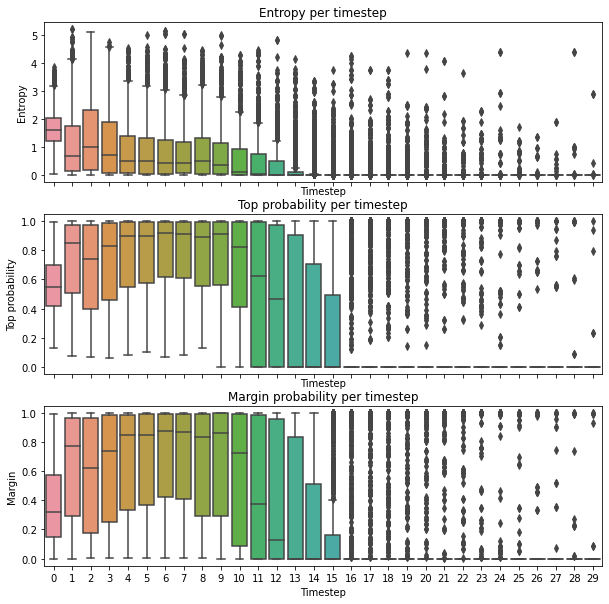

In [173]:
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
sns.boxplot(data=[entropy_per_timestep[:1740,i].tolist() for i in range(30)], ax=axes[0])
axes[0].set_title("Entropy per timestep")
axes[0].set_xlabel("Timestep")
axes[0].set_ylabel("Entropy")

sns.boxplot(data=[preds_raw_scores[:1740,i].tolist() for i in range(30)], ax=axes[1])
axes[1].set_title("Top probability per timestep")
axes[1].set_xlabel("Timestep")
axes[1].set_ylabel("Top probability")

sns.boxplot(data=[margin_per_timestep[:1740,i].tolist() for i in range(30)], ax=axes[2])
axes[2].set_title("Margin probability per timestep")
axes[2].set_xlabel("Timestep")
axes[2].set_ylabel("Margin")

In [177]:
from collections import Counter

preds_raw_str = np.vstack(df.preds_raw_str.values)
print(preds_raw_str.shape)

most_common_terms = {}
for timestep in range(30):
    most_common_terms[timestep] = Counter(preds_raw_str[:, timestep]).most_common(10)
    
most_common_terms

(3205, 99)


{0: [('▁', 1061),
  ('▁she', 298),
  ('▁to', 274),
  ('▁because', 209),
  ('▁they', 204),
  ('▁the', 188),
  ('▁that', 161),
  ('▁it', 89),
  ('▁his', 56),
  ('▁by', 41)],
 1: [('he', 757),
  ('▁', 311),
  ('a', 245),
  ('▁is', 117),
  ('▁are', 76),
  ('▁the', 68),
  ('▁was', 58),
  ('▁she', 57),
  ('▁they', 52),
  ('0', 48)],
 2: [('▁is', 250),
  ('▁', 233),
  ('he', 193),
  ('0', 135),
  ('▁was', 109),
  ('▁the', 96),
  ('s', 92),
  ('a', 63),
  ('▁of', 41),
  ('▁her', 40)],
 3: [('0', 300),
  ('▁', 284),
  ('s', 164),
  ('a', 101),
  ('▁is', 88),
  ('▁to', 85),
  ('▁of', 79),
  ('▁the', 76),
  ('▁his', 57),
  ('▁was', 53)],
 4: [('0', 477),
  ('▁', 228),
  ('a', 166),
  ('s', 120),
  ('▁the', 110),
  ('▁to', 72),
  ('.', 55),
  ('▁of', 50),
  ('▁in', 50),
  ('▁by', 45)],
 5: [('0', 734),
  ('a', 164),
  ('▁', 157),
  ('▁the', 110),
  ('▁to', 83),
  ('s', 77),
  ('.', 69),
  ('▁of', 53),
  ('▁with', 45),
  ('▁and', 43)],
 6: [('0', 981),
  ('▁', 140),
  ('.', 96),
  ('a', 94),
  ('▁t

In [ ]:
def get_example(example_id, answer_id, preds=batch1, matrix=df):
    example_id_mask = lambda df: df["example_id"] == example_id
    answer_id_mask = lambda df: df["answer_id"] == answer_id

    matrix_example = matrix[example_id_mask(matrix) & answer_id_mask(matrix)].to_dict()
    preds_example = preds[example_id_mask(preds) & answer_id_mask(preds)].to_dict()

    example = {}
    example.update(matrix_example)
    example.update(preds_example)
    
    print(f"\n\n Context: {example['context']}")
    print(f"\n Question: {example['question']}")
    print()
    print(f"\t\t Gold Answer: {example['labels']}")
    print(f"\t\t Pred Answer: {example['preds']}")
    
    roundn = lambda lst: [round(n, 3) for n in lst]
    
    print(f"\t\t\t Pred Answer Score:", example["score_proba"], ";\n\t\t\t", roundn(example["preds_raw_scores"]))
    return example

ex = get_example(example_id=10510, answer_id="31b35f4092bef33cb4044dcc560a8556");
ex.keys()

In [ ]:
batch

In [ ]:
i = 1 
for e in ex["preds_raw_scores"]:
    i *= e
    print(i)
i

In [ ]:
0.99**13

In [ ]:
entropy_per_timestep.max()

In [ ]:
10510

In [ ]:
batch1.tail(25)

In [ ]:
from scipy.stats import entropy

In [ ]:
batch_size = 2 
vocab_size = 5
example = torch.tensor(np.random.permutation(batch_size * vocab_size).reshape(batch_size, vocab_size) * 0.1)
example = torch.softmax(example, dim=-1)
example

In [ ]:
# Compute the entropy
entropy_per_timestep = [] 

k = 2
margin_per_timestep = []

for i in range(5): 
    example = np.random.permutation(batch_size * vocab_size).reshape(batch_size, vocab_size) *1.0
    example = torch.tensor(example)
    example = torch.softmax(example, dim=-1)
    print(example)

    topk_values, topk_indices = torch.topk(example, 2, dim=-1)
    margin = topk_values.max(dim=-1).values - topk_values.min(dim=-1).values
    print(margin, )
    margin_per_timestep.append(margin.reshape(batch_size, 1))
    break
torch.hstack(margin_per_timestep).tolist()

In [ ]:
example = np.random.permutation(batch_size * vocab_size).reshape(batch_size, vocab_size) *1.0
example = torch.tensor(example)
example

In [ ]:
topk_values, topk_indices = torch.topk(example, 2, dim=-1)
topk_indices

In [ ]:
topk_indices[0]

In [ ]:
# 
values, indices = torch.topk(example, 2, dim=-1)
values.shape, indices.shape

In [ ]:
indices

In [ ]:
# Use indices to get values of the top-k
torch.gather(example, dim=-1, index=indices)